In [1]:
import pandas as pd
import random
import math
from matplotlib import pyplot as plt
%matplotlib inline

import re
import nltk
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import gensim.downloader


In [2]:
full_train = pd.read_csv("../data/full_train_processed.csv").drop(columns = "Unnamed: 0")


In [4]:
balanced_test =pd.read_csv("../data/balanced_test_processed.csv").drop(columns = "Unnamed: 0")


# Feature engineering

#### Some functions to draw figures to evaluate usefulness of feature

In [386]:
def boxplot(df,col_name,ylim = None,title = ""):
    plt.boxplot([df[df["0"] == 1][col_name],
             df[df["0"] == 2][col_name],
             df[df["0"] == 3][col_name],
            df[df["0"] == 4][col_name]])
    plt.xticks([1,2,3,4],["Satire","Hoax","Propaganda","Reliable"])
    plt.title(title)
    plt.ylim(ylim)
    
def boxplot2(df1,df2,col_name,ylim = None,ylim2 = None,title = "", title2 = ""):
    fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    ax[0].boxplot([df1[df1["0"] == 1][col_name],
             df1[df1["0"] == 2][col_name],
             df1[df1["0"] == 3][col_name],
            df1[df1["0"] == 4][col_name]])
    ax[0].set_xticks([1,2,3,4],["Satire","Hoax","Propaganda","Reliable"])
    ax[0].set_title(title)
    ax[0].set_ylim(ylim)
    
    ax[1].boxplot([df2[df2["0"] == 1][col_name],
             df2[df2["0"] == 2][col_name],
             df2[df2["0"] == 3][col_name],
            df2[df2["0"] == 4][col_name]])
    ax[1].set_xticks([1,2,3,4],["Satire","Hoax","Propaganda","Reliable"])
    ax[1].set_title(title2)
    ax[1].set_ylim(ylim2)

In [6]:
def violinplot(df,col_name,ylim = None,title = ""):
    plt.violinplot([df[df["0"] == 1][col_name],
             df[df["0"] == 2][col_name],
             df[df["0"] == 3][col_name],
            df[df["0"] == 4][col_name]])
    plt.xticks([1,2,3,4],["Satire","Hoax","Propaganda","Reliable"])
    plt.title(title)
    plt.ylim(ylim)

In [383]:
def stackplot(df,col_name,ylim = None,title = ""):
    count_0 = list(df[df[col_name] == 0].groupby("0").count()[col_name])
    count_1 = list(df[df[col_name] == 1].groupby("0").count()[col_name])
    plt.bar(["Satire","Hoax","Propaganda","Reliable"], count_0, label=col_name + " absent")
    plt.bar(["Satire","Hoax","Propaganda","Reliable"], count_1, bottom=count_0,
           label= col_name +' present')
    plt.title(title)
    plt.legend()
    
def stackplot2(df1,df2,col_name,ylim = None,title = "",title2 = ""):
    fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    
    count_0 = list(df1[df1[col_name] == 0].groupby("0").count()[col_name])
    count_1 = list(df1[df1[col_name] == 1].groupby("0").count()[col_name])
    
    test_count_0 = list(df2[df2[col_name] == 0].groupby("0").count()[col_name])
    test_count_1 = list(df2[df2[col_name] == 1].groupby("0").count()[col_name])
    
    ax[0].bar(["Satire","Hoax","Propaganda","Reliable"], count_0, label=col_name + " absent")
    ax[0].bar(["Satire","Hoax","Propaganda","Reliable"], count_1, bottom=count_0,
           label= col_name +' present')
    ax[0].set_title(title)
    ax[0].legend()
    
    ax[1].bar(["Satire","Hoax","Propaganda","Reliable"], test_count_0, label=col_name + " absent")
    ax[1].bar(["Satire","Hoax","Propaganda","Reliable"], test_count_1, bottom=test_count_0,
           label= col_name +' present')
    ax[1].set_title(title2)
    ax[1].legend()

### Feature: Length

In [8]:
def get_length(x):
    return len(x.split(" "))

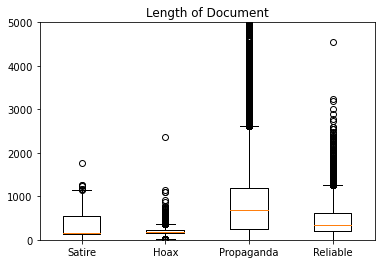

In [12]:
full_train["length"] = full_train["1"].apply(get_length)
boxplot(full_train,"length",(0,5000),"Length of Document") # Truncated plot

### Feature: Number of quotations

In [11]:
def num_quotes(x):
    return len(re.findall("[\"\']",x))

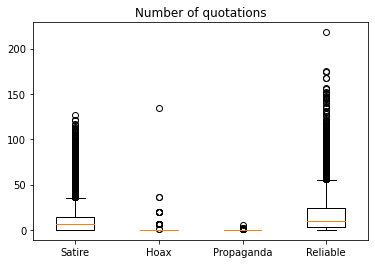

In [14]:
full_train["num_quotes"] = full_train["1"].apply(num_quotes)
boxplot(full_train,"num_quotes",None,"Number of quotations")

### Feature: Number of first person singular and Number of third person plural

In [17]:
def num_firstperson_singular(x):
    return len(re.findall("(?:^|\W)(i|me|my|mine|myself)(?:$|\W)",x.lower()))

def num_thirdperson_plural(x):
    return len(re.findall("(?:^|\W)(they|them|themselves|theirs)(?:$|\W)",x.lower()))

In [18]:
full_train["num_firstperson"] = full_train["1"].apply(num_firstperson_singular)
full_train["num_thirdperson"] = full_train["1"].apply(num_thirdperson_plural)

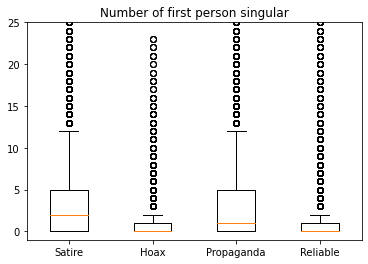

In [25]:
boxplot(full_train, "num_firstperson",(-1,25),"Number of first person singular")

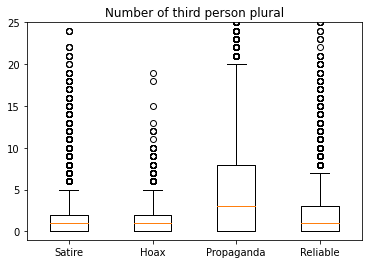

In [26]:
boxplot(full_train, "num_thirdperson",(-1,25),"Number of third person plural")

### Feature: Count of numbers

In [27]:
def num_numbers(x):
    return len(re.findall("\d+",x.lower()))

In [28]:
full_train["num_numbers"] = full_train["1"].apply(num_numbers)

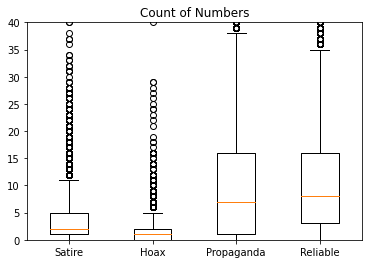

In [30]:
boxplot(full_train,"num_numbers",(0,40),"Count of Numbers")

### Feature: Presence of Profanity

In [35]:
# source: https://github.com/boriel/perlfunc
from perlfunc import perl5lib, perlfunc, perlreq

@perlfunc
@perlreq('./Regexp-common/lib/detect_profanity.pl')
def profanity_(a):
    pass 


In [36]:
# source: https://metacpan.org/pod/Regexp::Common::profanity#$RE%7Bprofanity%7D
def profanity(x):
    return profanity_(x)


In [38]:
full_train["profanity"] = full_train.loc[:,"processed"].apply(profanity)
full_train["profanity"] = full_train["profanity"].map(int)


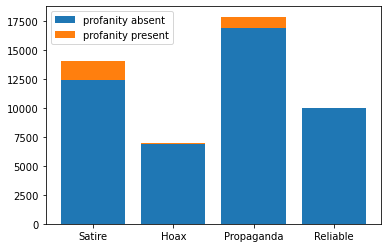

In [374]:
stackplot(full_train,"profanity")


### Feature: Sentiments

In [49]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
senti = SentimentIntensityAnalyzer()

#### Negative score

In [50]:
def neg(x):
    return senti.polarity_scores(x)['neg']
full_train["neg"] = full_train.loc[:,"1"].apply(neg)

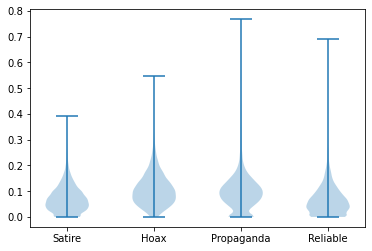

In [51]:
violinplot(full_train,"neg")

#### Positive score

In [53]:
def pos(x):
    return senti.polarity_scores(x)['pos']
full_train["pos"] = full_train.loc[:,"1"].apply(pos)

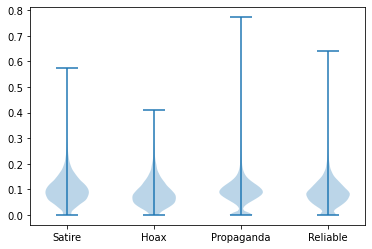

In [63]:
violinplot(full_train,"pos")

#### Neutral score

In [54]:
def neu(x):
    return senti.polarity_scores(x)['neu']
full_train["neu"] = full_train.loc[:,"1"].apply(neu)

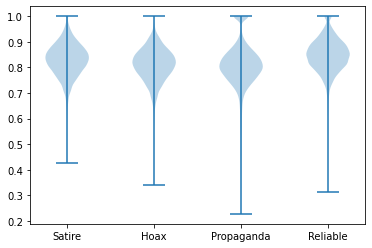

In [64]:
violinplot(full_train,"neu")

#### Compound score

In [55]:
def compound(x):
    return senti.polarity_scores(x)['compound']
full_train["compound"] = full_train.loc[:,"1"].apply(compound)

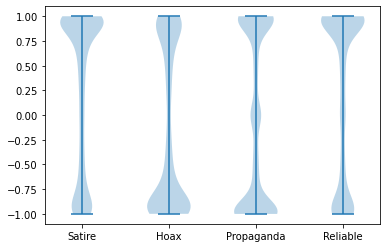

In [65]:
violinplot(full_train,"compound")

### Feature: Hedging words

In [56]:
#source: http://jal.iaut.ac.ir/article_524171_19ce974d4c9441a312df2d6eaac20a15.pdf
#https://hal.inria.fr/hal-03342756/file/Besancon__Definitely_Maybe__preprint%20%281%29.pdf

modal = "Can Could May Might Should Will Would" 
re_modal = "(?:^|\W)(" + "|".join(modal.lower().split(" ")) + ")(?:$|\W)"

lexical = "Appear Argue Assert Assume Attempt Believe Claim Conclude Consider Doubt Estimate Evaluate Expect Feel Hypothesize Imply Indicate Interpret Maintain Note Offer Observe Perceive Presume Propose Prove Report Seem Seen Speculate Suggest Suppose Suspect Tend Think"
lexical_s = [i + "s" for i in lexical.lower().split(" ")]
re_lexical = "(?:^|\W)(" + "|".join(lexical.lower().split(" ") + lexical_s) + "|attempt to|can be seen" + ")(?:$|\W)"

adverbs = "About Allegedly Almost Apparently Approximately Around Arguably Barely Commonly Conceivably Considerably Doubtless Fairly Frequently Generally Given that Greatly Highly Hypothetically Largely Likely Mainly Markedly Maybe Modestly Mostly Nearly Normally Occasionally Often Partially Partly Perhaps Possibly Potentially Practically Presumably Primarily Probably Provided Quite Rarely Reasonably Relatively Reportedly Roughly Seemingly Seldom Significantly Slightly Sometimes Somewhat Strongly Substantially Supposedly Tentatively Theoretically Typically Unlikely Usually Vastly Virtually Widely" 
re_adverbs = "(?:^|\W)(" + "|".join(adverbs.lower().split(" ")) + "|provided that" + ")(?:$|\W)"

adjectives = "Apparent Approximate Common Conceivable Considerable Consistent with Frequent General Hypothetical Improbable Indicative Large Likely Little Main Major Modest Noticeable Plausible Possible Potential Primary Probable Rare Relative Remarkable Rough Significant Slight Small Substantial Theoretical Typical Uncommon Unlikely Usual Well-Known" 
re_adjectives = "(?:^|\W)(" + "|".join(adjectives.lower().split(" ")) + ")(?:$|\W)"

nouns = "Alternative Approximation Assertion Assessment Assumption Belief Chance Claim Conclusion Doubt Estimate Estimation Evaluation Expectation Hope Idea Implication Indication Interpretation Likelihood Opinion Possibility Premise Probability Proposal Suggestion Tendency View"
re_nouns = "(?:^|\W)(" + "|".join(nouns.lower().split(" ")) + ")(?:$|\W)"

#### Presence of hedges in document

In [69]:
def hedges(x):
    if (len(re.findall(re_modal,x.lower())) + 
            len(re.findall(re_lexical,x.lower())) + 
            len(re.findall(re_adverbs,x.lower())) +
            len(re.findall(re_adjectives,x.lower())) +
            len(re.findall(re_nouns,x.lower()))) == 0:
        return 0
    else:
        return 1
    
full_train["hedges"] = full_train.loc[:,"processed"].apply(hedges)

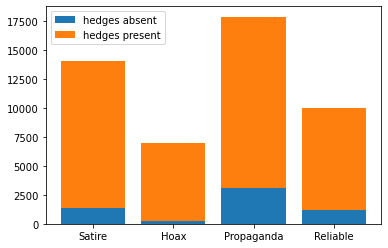

In [375]:
stackplot(full_train,"hedges")

### Feature: Booster words

In [60]:
#source: http://jal.iaut.ac.ir/article_524171_19ce974d4c9441a312df2d6eaac20a15.pdf
#https://hal.inria.fr/hal-03342756/file/Besancon__Definitely_Maybe__preprint%20%281%29.pdf

modal_boosters = "Can't Cant Cannot Couldn't Couldnt Must Will Won't Wont Would Wouldn't Wouldnt"
re_modal_boosters = "(?:^|\W)(" + "|".join(modal_boosters.lower().split(" ")) + "|could not|can not|will not|would not" + ")(?:$|\W)"

lexical_boosters = "Assure Assures Confirm Confirms Demonstrate Demonstrates Do Does Establish Establishes Find Finds Indicate Indicates Know Knows Predict Predicts Reinforce Reinforces Show Shows" 
re_lexical_boosters = "(?:^|\W)(" + "|".join(lexical_boosters.lower().split(" ")) + ")(?:$|\W)"

adverbs_boosters = "Absolutely Actually Always Assuredly Basically Certainly Clearly Completely Definitely Entirely Essentially Evidently Exactly Explicitly Extremely Factually Fully Fundamentally Indeed Indisputably Inevitably Intensively Necessarily Never Obviously Patently Plainly Precisely Really Surely Truly Totally Thoroughly Unarguably Undeniably Undoubtedly Unquestionably" 
re_adverbs_boosters = "(?:^|\W)(" + "|".join(adverbs_boosters.lower().split(" ")) + "in fact|no doubt|of course " + ")(?:$|\W)"

adjectives_boosters = "Absolute Certain Clear Complete Confident Definite Essential Evident Exact Extreme Impossible Inevitable Obvious Really Perfect Plain Real Sure Thorough Total True" 
re_adjectives_boosters = "(?:^|\W)(" + "|".join(adjectives_boosters.lower().split(" ")) + ")(?:$|\W)"

nouns_boosters = "Certainty Certainties Confidence Confidences Evidence Evidences Fact FactsPrecision Precisions"
re_nouns_boosters = "(?:^|\W)(" + "|".join(nouns_boosters.lower().split(" ")) + ")(?:$|\W)"

#### Presence of Boosters in document

In [78]:
def boosters(x):
    if (len(re.findall(re_modal_boosters,x.lower())) + 
            len(re.findall(re_lexical_boosters,x.lower())) + 
            len(re.findall(re_adverbs_boosters,x.lower())) +
            len(re.findall(re_adjectives_boosters,x.lower())) +
            len(re.findall(re_nouns_boosters,x.lower()))) == 0:
        return 0
    else:
        return 1
    
full_train["boosters"] = full_train.loc[:,"processed"].apply(boosters)

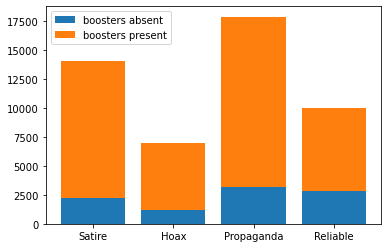

In [376]:
stackplot(full_train,"boosters")

Therefore, from the plots using the training set, the features that are useful are: 
1. Length
2. Number of quotations
3. Count of numbers
4. Profanity
5. Compound Score
6. Presence of hedges

In [80]:
# only use features that are useful in distinguishing the classes
train_filtered = full_train.drop(columns =["num_firstperson","num_thirdperson","neg","pos","neu","boosters"])

In [82]:
# create feature for test set
balanced_test["length"] = balanced_test.loc[:,"1"].apply(get_length)
balanced_test["num_quotes"] = balanced_test.loc[:,"1"].apply(num_quotes)
balanced_test["num_numbers"] = balanced_test.loc[:,"1"].apply(num_numbers)
balanced_test["profanity"] = balanced_test.loc[:,"processed"].apply(profanity)
balanced_test["profanity"] = balanced_test["profanity"].map(int)
balanced_test["compound"] = balanced_test.loc[:,"1"].apply(compound)
balanced_test["hedges"] = balanced_test.loc[:,"processed"].apply(hedges)


### Word2vec

In [83]:
# load embeddings
model = gensim.downloader.load('glove-wiki-gigaword-300')

In [84]:
sentences = [re.sub('[\.?!,:;]', "",list(full_train["processed"])[i]).split(" ") for i in range(len(list(full_train["processed"])))]
test_sentences = [re.sub('[\.?!,:;]', "",list(balanced_test["processed"])[i]).split(" ") for i in range(len(list(balanced_test["processed"])))]

In [85]:
all_res = []
for i in range(len(sentences)):
    curr = sentences[i]
    res = []
    for j in range(len(curr)):
        try: 
            res.append(model[curr[j]])
        except Exception as e:
            pass
    res = np.array(res)
    res = np.mean(res,axis = 0)
    if np.isnan(res).all():
        res = np.zeros(all_res[-1].shape)
    all_res.append(res)

/Users/admin/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/admin/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [216]:
vec_df = pd.DataFrame(all_res)
train_vec = pd.concat([train_filtered.reset_index(),vec_df],axis = 1).drop(columns="index")

In [88]:
all_res_test = []
for i in range(len(test_sentences)):
    curr = test_sentences[i]
    res = []
    for j in range(len(curr)):
        try:
            res.append(model[curr[j]])
        except Exception as e:
            pass
    res = np.array(res)
    res = np.mean(res,axis = 0)
    if np.isnan(res).all():
        res = np.zeros(all_res[-1].shape)
    all_res_test.append(res)

In [217]:
vec_df_test = pd.DataFrame(all_res_test)
test_vec = pd.concat([balanced_test.reset_index(),vec_df_test],axis = 1).drop(columns="index")


In [155]:
def predict_nn(model, X_test):
    test_pred = model.predict(np.array(X_test))
    result = []
    test_pred = np.argmax(test_pred,axis = 1)
    for i in test_pred:
        result.append(i+1)        
    return np.array(result)

#### Split into Train and Validation set (80:20)

In [218]:
random.seed(10)
idxs = list(train_vec.index)
random.shuffle(idxs) #randomly split into train and validation set using indexes

num_train = math.ceil(len(train_vec)*0.8)

train_idxs = idxs[:num_train]
valid_idxs = idxs[num_train:]

train_df = train_vec.iloc[train_idxs,:]
valid_df = train_vec.iloc[valid_idxs,:]

Text(0.5, 1.0, 'Valid set distribution')

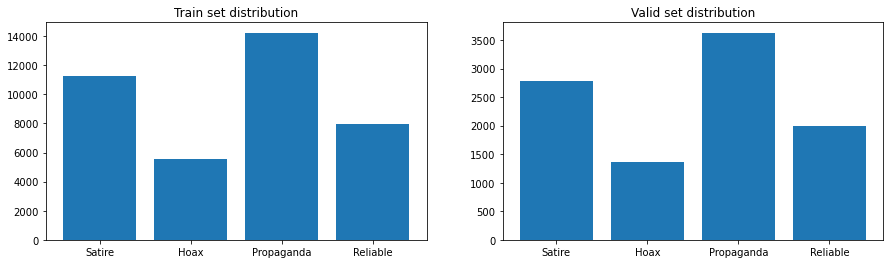

In [158]:
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4))
ax[0].bar(["Satire","Hoax","Propaganda","Reliable"],train_df.groupby("0").count()["processed"])
ax[0].set_title("Train set distribution")
ax[1].bar(["Satire","Hoax","Propaganda","Reliable"],valid_df.groupby("0").count()["processed"])
ax[1].set_title("Valid set distribution")

### Using only word embeddings

In [219]:
ytrain_map = []
for i in train_df.iloc[:,0]:
    ytrain_map.append(i-1)

yvalid_map = []
for i in valid_df.iloc[:,0]:
    yvalid_map.append(i-1)

In [232]:
scaler = StandardScaler().fit(train_df.iloc[:,9:])
Xtrain_scaled_wb = pd.DataFrame(scaler.transform(train_df.iloc[:,9:]))
Xvalid_scaled_wb = pd.DataFrame(scaler.transform(valid_df.iloc[:,9:]))
Xtest_scaled_wb = pd.DataFrame(scaler.transform(test_vec.iloc[:,9:]))

In [281]:
xtrain = np.array(Xtrain_scaled_wb)
ytrain = np.array(ytrain_map).reshape(-1,1)

xvalid = np.array(Xvalid_scaled_wb)
yvalid = np.array(yvalid_map).reshape(-1,1)

nn = tf.keras.Sequential()
nn.add(tf.keras.Input(shape = (xtrain.shape[1],)))
nn.add(tf.keras.layers.Dense(40,activation = "sigmoid",kernel_regularizer=tf.keras.regularizers.l2(0.001)))
nn.add(tf.keras.layers.Dense(40,activation = "sigmoid",kernel_regularizer=tf.keras.regularizers.l2(0.001)))
nn.add(tf.keras.layers.Dense(4))
print(nn.summary())

opti =  tf.keras.optimizers.Adam(learning_rate = 0.001)
nn.compile(optimizer =opti, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

nn.fit(xtrain, ytrain, batch_size = 128,epochs = 100, validation_data = (xvalid,yvalid))

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 40)                12040     
                                                                 
 dense_148 (Dense)           (None, 40)                1640      
                                                                 
 dense_149 (Dense)           (None, 4)                 164       
                                                                 
Total params: 13,844
Trainable params: 13,844
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
306/306 [==============================] - 1s 2ms/step - loss: 0.8507 - accuracy: 0.7478 - val_loss: 0.5811 - val_accuracy: 0.8511
Epoch 2/100
306/306 [==============================] - 1s 2ms/step - loss: 0.5511 - accuracy: 0.8565 - val_loss: 0.5049 - val_accuracy: 0.8672
Epoch 3/100
306/306 [=

In [237]:
pred_nn = predict_nn(nn,Xvalid_scaled_wb)
print(classification_report(valid_df.iloc[:,0],pred_nn))

              precision    recall  f1-score   support

           1       0.89      0.91      0.90      2777
           2       0.87      0.89      0.88      1369
           3       0.94      0.93      0.93      3627
           4       0.88      0.87      0.88      1997

    accuracy                           0.91      9770
   macro avg       0.90      0.90      0.90      9770
weighted avg       0.91      0.91      0.91      9770



In [282]:
pred_nn = predict_nn(nn,Xtest_scaled_wb)
print(classification_report(test_vec.iloc[:,0],pred_nn))

              precision    recall  f1-score   support

           1       0.73      0.69      0.71       750
           2       0.67      0.57      0.62       750
           3       0.69      0.82      0.75       750
           4       0.81      0.83      0.82       750

    accuracy                           0.73      3000
   macro avg       0.73      0.73      0.72      3000
weighted avg       0.73      0.73      0.72      3000



In [336]:
# Train with both Train and Validation set
nn = tf.keras.Sequential()
nn.add(tf.keras.Input(shape = (xtrain.shape[1],)))
nn.add(tf.keras.layers.Dense(40,activation = "sigmoid",kernel_regularizer=tf.keras.regularizers.l2(0.001)))
nn.add(tf.keras.layers.Dense(40,activation = "sigmoid",kernel_regularizer=tf.keras.regularizers.l2(0.001)))
nn.add(tf.keras.layers.Dense(4))
print(nn.summary())

opti =  tf.keras.optimizers.Adam(learning_rate = 0.001)
nn.compile(optimizer =opti, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

nn.fit(np.array(pd.concat([Xtrain_scaled_wb,Xvalid_scaled_wb])), np.array(ytrain_map + yvalid_map).reshape(-1,1), batch_size = 128,epochs = 100)

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_222 (Dense)           (None, 40)                12040     
                                                                 
 dense_223 (Dense)           (None, 40)                1640      
                                                                 
 dense_224 (Dense)           (None, 4)                 164       
                                                                 
Total params: 13,844
Trainable params: 13,844
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
382/382 [==============================] - 1s 1ms/step - loss: 0.8162 - accuracy: 0.7577
Epoch 2/100
382/382 [==============================] - 0s 1ms/step - loss: 0.5249 - accuracy: 0.8613
Epoch 3/100
382/382 [==============================] - 0s 1ms/step - loss: 0.4839 - accuracy: 0.8698
Epoch

In [337]:
pred_nn = predict_nn(nn,Xtest_scaled_wb)
print(classification_report(test_vec.iloc[:,0],pred_nn))


              precision    recall  f1-score   support

           1       0.72      0.74      0.73       750
           2       0.71      0.51      0.59       750
           3       0.68      0.89      0.77       750
           4       0.87      0.81      0.84       750

    accuracy                           0.74      3000
   macro avg       0.74      0.74      0.73      3000
weighted avg       0.74      0.74      0.73      3000



In [280]:
# save weights
nn.save("glove300_weights_acc=0.74_f1=0.73")

INFO:tensorflow:Assets written to: glove300_weights_acc=0.74_f1=0.73/assets


### Word embeddings + features

In [339]:
scaler = StandardScaler().fit(train_df.iloc[:,3:])
Xtrain_scaled_both = pd.DataFrame(scaler.transform(train_df.iloc[:,3:]))
Xvalid_scaled_both = pd.DataFrame(scaler.transform(valid_df.iloc[:,3:]))
Xtest_scaled_both = pd.DataFrame(scaler.transform(test_vec.iloc[:,3:]))

/Users/admin/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/admin/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/admin/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/admin/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised i

In [353]:
xtrain = np.array(Xtrain_scaled_both)
ytrain = np.array(ytrain_map).reshape(-1,1)

xvalid = np.array(Xvalid_scaled_both)
yvalid = np.array(yvalid_map).reshape(-1,1)

nn = tf.keras.Sequential()
nn.add(tf.keras.Input(shape = (xtrain.shape[1],)))
nn.add(tf.keras.layers.Dense(20,activation = "sigmoid",kernel_regularizer=tf.keras.regularizers.l2(0.01)))
nn.add(tf.keras.layers.Dense(20,activation = "sigmoid",kernel_regularizer=tf.keras.regularizers.l2(0.01)))
nn.add(tf.keras.layers.Dense(4))
print(nn.summary())

opti =  tf.keras.optimizers.Adam(learning_rate = 0.001)
nn.compile(optimizer =opti, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

nn.fit(xtrain, ytrain, batch_size = 128,epochs = 50, validation_data = (xvalid,yvalid))

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_243 (Dense)           (None, 20)                6140      
                                                                 
 dense_244 (Dense)           (None, 20)                420       
                                                                 
 dense_245 (Dense)           (None, 4)                 84        
                                                                 
Total params: 6,644
Trainable params: 6,644
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
306/306 [==============================] - 1s 2ms/step - loss: 1.3352 - accuracy: 0.6209 - val_loss: 1.0439 - val_accuracy: 0.7426
Epoch 2/50
306/306 [==============================] - 0s 1ms/step - loss: 0.9573 - accuracy: 0.7843 - val_loss: 0.8662 - val_accuracy: 0.8375
Epoch 3/50
306/306 [======

In [354]:
pred_nn = predict_nn(nn,Xtest_scaled_both)
print(classification_report(test_vec.iloc[:,0],pred_nn))

              precision    recall  f1-score   support

           1       0.62      0.71      0.66       750
           2       0.61      0.38      0.47       750
           3       0.48      0.57      0.52       750
           4       0.73      0.78      0.76       750

    accuracy                           0.61      3000
   macro avg       0.61      0.61      0.60      3000
weighted avg       0.61      0.61      0.60      3000



In [355]:
# Train on both training and validation set
nn = tf.keras.Sequential()
nn.add(tf.keras.Input(shape = (Xtrain_scaled_both.shape[1],)))
nn.add(tf.keras.layers.Dense(20,activation = "sigmoid",kernel_regularizer=tf.keras.regularizers.l2(0.01)))
nn.add(tf.keras.layers.Dense(20,activation = "sigmoid",kernel_regularizer=tf.keras.regularizers.l2(0.01)))
nn.add(tf.keras.layers.Dense(4))
print(nn.summary())

opti =  tf.keras.optimizers.Adam(learning_rate = 0.001)
#nn.compile(optimizer =opti, loss='categorical_crossentropy', metrics = ['accuracy'])
nn.compile(optimizer =opti, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

nn.fit(np.array(pd.concat([Xtrain_scaled_both,Xvalid_scaled_both])), np.array(ytrain_map + yvalid_map).reshape(-1,1), batch_size = 128,epochs = 50)

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_246 (Dense)           (None, 20)                6140      
                                                                 
 dense_247 (Dense)           (None, 20)                420       
                                                                 
 dense_248 (Dense)           (None, 4)                 84        
                                                                 
Total params: 6,644
Trainable params: 6,644
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
382/382 [==============================] - 1s 2ms/step - loss: 1.3657 - accuracy: 0.5881
Epoch 2/50
382/382 [==============================] - 1s 1ms/step - loss: 0.9531 - accuracy: 0.7907
Epoch 3/50
382/382 [==============================] - 1s 1ms/step - loss: 0.8306 - accuracy: 0.8290
Epoch 4/50

In [356]:
pred_nn = predict_nn(nn,Xtest_scaled_both)
print(classification_report(test_vec.iloc[:,0],pred_nn))

              precision    recall  f1-score   support

           1       0.64      0.69      0.66       750
           2       0.62      0.44      0.52       750
           3       0.50      0.57      0.53       750
           4       0.74      0.79      0.77       750

    accuracy                           0.62      3000
   macro avg       0.63      0.62      0.62      3000
weighted avg       0.63      0.62      0.62      3000



### Train and test distribution for features used

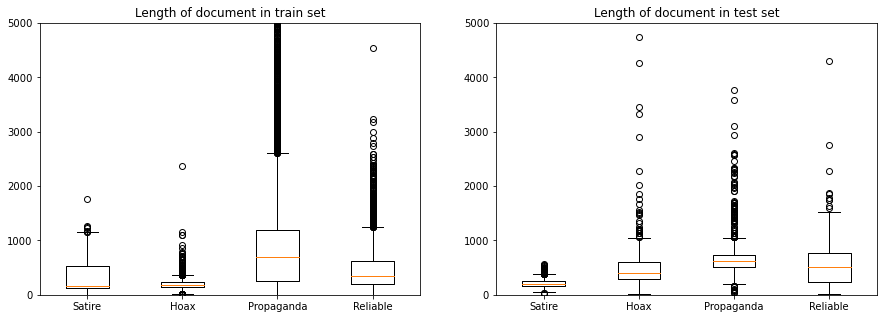

In [387]:
boxplot2(train_filtered,balanced_test,"length",(0,5000),(0,5000),"Length of document in train set","Length of document in test set")

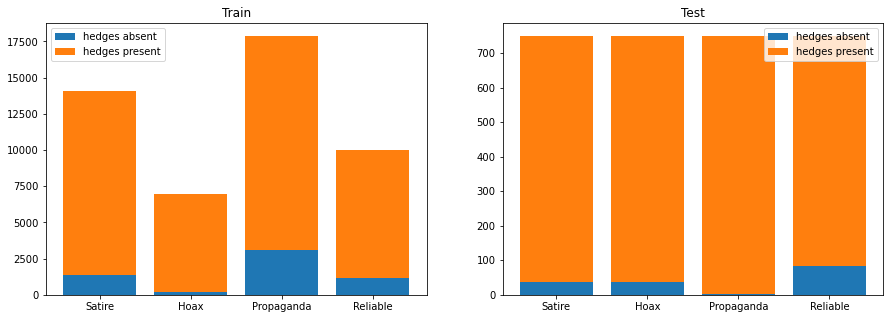

In [385]:
stackplot2(train_filtered,balanced_test,"hedges",None,"Train","Test")